<a href="https://colab.research.google.com/github/mansipatel2508/Yelp-Review-Stars-Prediction-with-Machine-Learning/blob/master/Additional_Mini_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
#Mini Project 3
1.Feature Selection 
2.Multi classification

Mansi Patel
Megha Mathpal
```



In [0]:
import os
import json
import csv
import pandas as pd
import numpy as np
import collections
from scipy.stats import zscore
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 21.0MB/s 


AttributeError: ignored

In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
link = 'https://drive.google.com/open?id=1ZbKs_u3c4gZM-Uq0h1RCVXl6p7PnCSTf'
fluff, file_id = link.split('=')
print (file_id)
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('network_intrusion_data.csv')  
df = pd.read_csv('network_intrusion_data.csv')
df2 = pd.read_csv('network_intrusion_data.csv')
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

1ZbKs_u3c4gZM-Uq0h1RCVXl6p7PnCSTf


#Gems to use

In [0]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [0]:
df.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]
df2.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]

In [0]:
df.shape

(494020, 42)

In [0]:
df.head()

duration protocol_type service flag  src_bytes  dst_bytes  land  \
0  0         tcp           http    SF   239        486        0      
1  0         tcp           http    SF   235        1337       0      
2  0         tcp           http    SF   219        1337       0      
3  0         tcp           http    SF   217        2032       0      
4  0         tcp           http    SF   217        2032       0      

   wrong_fragment  urgent  hot   ...     dst_host_srv_count  \
0  0               0       0     ...     19                   
1  0               0       0     ...     29                   
2  0               0       0     ...     39                   
3  0               0       0     ...     49                   
4  0               0       0     ...     59                   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0  1.0                     0.0                      
1  1.0                     0.0                      
2  1.0                     0.0                      
3  1.0                     0.0                      
4  1.0                     0.0                      

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0  0.05                         0.0                           
1  0.03                         0.0                           
2  0.03                         0.0                           
3  0.02                         0.0                           
4  0.02                         0.0                           

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0  0.0                   0.0                       0.0                    
1  0.0                   0.0                       0.0                    
2  0.0                   0.0                       0.0                    
3  0.0                   0.0                       0.0                    
4  0.0                   0.0                       0.0                    

   dst_host_srv_rerror_rate  outcome  
0  0.0                       normal.  
1  0.0                       normal.  
2  0.0                       normal.  
3  0.0                       normal.  
4  0.0                       normal.  

[5 rows x 42 columns]

In [0]:
df.dtypes

duration                       int64  
protocol_type                  object 
service                        object 
flag                           object 
src_bytes                      int64  
dst_bytes                      int64  
land                           int64  
wrong_fragment                 int64  
urgent                         int64  
hot                            int64  
num_failed_logins              int64  
logged_in                      int64  
num_compromised                int64  
root_shell                     int64  
su_attempted                   int64  
num_root                       int64  
num_file_creations             int64  
num_shells                     int64  
num_access_files               int64  
num_outbound_cmds              int64  
is_host_login                  int64  
is_guest_login                 int64  
count                          int64  
srv_count                      int64  
serror_rate                    float64
srv_serror_rate          

In [0]:
df.outcome.value_counts()

smurf.              280790
neptune.            107201
normal.             97277 
back.               2203  
satan.              1589  
ipsweep.            1247  
portsweep.          1040  
warezclient.        1020  
teardrop.           979   
pod.                264   
nmap.               231   
guess_passwd.       53    
buffer_overflow.    30    
land.               21    
warezmaster.        20    
imap.               12    
rootkit.            10    
loadmodule.         9     
ftp_write.          8     
multihop.           7     
phf.                4     
perl.               3     
spy.                2     
Name: outcome, dtype: int64

In [0]:
df.service.value_counts()

ecr_i          281400
private        110893
http           64292 
smtp           9723  
other          7237  
domain_u       5863  
ftp_data       4721  
eco_i          1642  
ftp            798   
finger         670   
urp_i          538   
telnet         513   
ntp_u          380   
auth           328   
pop_3          202   
time           157   
csnet_ns       126   
remote_job     120   
gopher         117   
imap4          117   
domain         116   
discard        116   
systat         115   
iso_tsap       115   
shell          112   
echo           112   
rje            111   
sql_net        110   
whois          110   
printer        109   
              ...    
bgp            106   
uucp_path      106   
uucp           106   
vmnet          106   
ssh            105   
supdup         105   
nnsp           105   
login          104   
hostnames      104   
efs            103   
daytime        103   
netbios_ns     102   
link           102   
pop_2          101   
ldap      

In [0]:
df.protocol_type.value_counts()

icmp    283602
tcp     190064
udp     20354 
Name: protocol_type, dtype: int64

In [0]:
df.flag.value_counts()

SF        378439
S0        87007 
REJ       26875 
RSTR      903   
RSTO      579   
SH        107   
S1        57    
S2        24    
RSTOS0    11    
S3        10    
OTH       8     
Name: flag, dtype: int64

In [0]:
#some columns does have only one value creates noisy data
print (df.num_outbound_cmds.value_counts())
df.is_host_login.value_counts()

0    494020
Name: num_outbound_cmds, dtype: int64


0    494020
Name: is_host_login, dtype: int64

#data preprocessing

In [0]:
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, outcome]
Index: []

[0 rows x 42 columns]

In [0]:
print(df.shape)
# if any' values are missing in a row, then drop that row. If inplace=True, do operation inplace and return None.
df.dropna(how='any', inplace= True)
df2.dropna(how='any', inplace= True)

(494020, 42)


In [0]:
df.shape

(494020, 42)

In [0]:
#removing duplicate rows
df.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df.shape

(145585, 42)

In [0]:


df.drop('num_outbound_cmds',inplace= True,axis=1)
df.drop('is_host_login',inplace= True,axis=1)
df2.drop('num_outbound_cmds',inplace= True,axis=1)
df2.drop('is_host_login',inplace= True,axis=1)

In [0]:
df.shape

(145585, 40)

#bad-good connection

In [0]:
def get_connection (row):
    if row['outcome'] == 'normal.':
        return 0
    else:
        return 1

In [0]:
df['connection_type'] = df.apply (lambda x: get_connection (x),axis=1)

In [0]:
df.connection_type.value_counts()

0    87831
1    57754
Name: connection_type, dtype: int64

In [0]:
df.describe

<bound method NDFrame.describe of         duration protocol_type service flag  src_bytes  dst_bytes  land  \
0       0         tcp           http    SF   239        486        0      
1       0         tcp           http    SF   235        1337       0      
2       0         tcp           http    SF   219        1337       0      
3       0         tcp           http    SF   217        2032       0      
4       0         tcp           http    SF   217        2032       0      
5       0         tcp           http    SF   212        1940       0      
6       0         tcp           http    SF   159        4087       0      
7       0         tcp           http    SF   210        151        0      
8       0         tcp           http    SF   212        786        0      
9       0         tcp           http    SF   210        624        0      
10      0         tcp           http    SF   177        1985       0      
11      0         tcp           http    SF   222        773       

#One hot encoding

In [0]:
df.dtypes

duration                       int64  
protocol_type                  object 
service                        object 
flag                           object 
src_bytes                      int64  
dst_bytes                      int64  
land                           int64  
wrong_fragment                 int64  
urgent                         int64  
hot                            int64  
num_failed_logins              int64  
logged_in                      int64  
num_compromised                int64  
root_shell                     int64  
su_attempted                   int64  
num_root                       int64  
num_file_creations             int64  
num_shells                     int64  
num_access_files               int64  
is_guest_login                 int64  
count                          int64  
srv_count                      int64  
serror_rate                    float64
srv_serror_rate                float64
rerror_rate                    float64
srv_rerror_rate          

In [0]:
#one hot encoding of protocol type, service and flag columns
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
df.shape

(145585, 118)

In [0]:
#droping the column outcome
df.drop('outcome',1,inplace=True)

In [0]:
df.dtypes

duration                  int64  
src_bytes                 int64  
dst_bytes                 int64  
land                      int64  
wrong_fragment            int64  
urgent                    int64  
hot                       int64  
num_failed_logins         int64  
logged_in                 int64  
num_compromised           int64  
root_shell                int64  
su_attempted              int64  
num_root                  int64  
num_file_creations        int64  
num_shells                int64  
num_access_files          int64  
is_guest_login            int64  
count                     int64  
srv_count                 int64  
serror_rate               float64
srv_serror_rate           float64
rerror_rate               float64
srv_rerror_rate           float64
same_srv_rate             float64
diff_srv_rate             float64
srv_diff_host_rate        float64
dst_host_count            int64  
dst_host_srv_count        int64  
dst_host_same_srv_rate    float64
dst_host_diff_

In [0]:
#normalize the count and numbers of columns that are continous with zscore-normalization
encode_numeric_zscore(df,'duration')
encode_numeric_zscore(df,'src_bytes')
encode_numeric_zscore(df,'dst_bytes')
encode_numeric_zscore(df,'wrong_fragment')
encode_numeric_zscore(df,'urgent')
encode_numeric_zscore(df,'hot')
encode_numeric_zscore(df,'num_failed_logins')
encode_numeric_zscore(df,'num_compromised')
encode_numeric_zscore(df,'num_root')
encode_numeric_zscore(df,'num_file_creations')
encode_numeric_zscore(df,'num_shells' )
encode_numeric_zscore(df,'num_access_files')
encode_numeric_zscore(df,'count')
encode_numeric_zscore(df,'srv_count')
encode_numeric_zscore(df,'dst_host_count')
encode_numeric_zscore(df,'dst_host_srv_count')

In [0]:
print(df.columns)
df.shape

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag-REJ', 'flag-RSTO', 'flag-RSTOS0', 'flag-RSTR', 'flag-S0',
       'flag-S1', 'flag-S2', 'flag-S3', 'flag-SF', 'flag-SH'],
      dtype='object', length=117)


(145585, 117)

In [0]:
#checking if the data after normalise give null values or not
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

#Feature Importance Analysis

##Pearson's Coefficient Correlation

In [0]:
#printing out the correlation of the features with the color map
df.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


In [0]:
df_corr = df.corr()
df_corr

duration  src_bytes  dst_bytes      land  \
duration                1.000000  0.004280   0.002582  -0.001264   
src_bytes               0.004280  1.000000  -0.000162  -0.000051   
dst_bytes               0.002582 -0.000162   1.000000  -0.000551   
land                   -0.001264 -0.000051  -0.000551   1.000000   
wrong_fragment         -0.009102 -0.000365  -0.003969  -0.000989   
urgent                  0.003707 -0.000018   0.016147  -0.000056   
hot                     0.009855  0.003999   0.000658  -0.000823   
num_failed_logins       0.004343 -0.000077   0.048789  -0.000211   
logged_in              -0.090667 -0.000928   0.028106  -0.011524   
num_compromised         0.061454  0.000025   0.022755  -0.000093   
root_shell              0.021395 -0.000075   0.031076  -0.000228   
su_attempted            0.058895 -0.000033   0.075442  -0.000101   
num_root                0.059745 -0.000038   0.020425  -0.000122   
num_file_creations      0.078000 -0.000043   0.004285  -0.000243   
num_shells             -0.001435 -0.000045  -0.000454  -0.000214   
num_access_files        0.023886 -0.000191   0.007099  -0.000596   
is_guest_login          0.020268 -0.000270  -0.000959  -0.000806   
count                  -0.078037 -0.001727  -0.032532  -0.008112   
srv_count              -0.040819 -0.001438  -0.009519  -0.004276   
serror_rate            -0.069312  0.001787  -0.029805   0.017473   
srv_serror_rate        -0.069252  0.001096  -0.029837   0.018309   
rerror_rate             0.004626  0.000315  -0.016049  -0.002840   
srv_rerror_rate         0.004850  0.001367  -0.015748  -0.004115   
same_srv_rate           0.059618 -0.002217   0.036113   0.006869   
diff_srv_rate           0.051852  0.007307  -0.014592   0.001307   
srv_diff_host_rate     -0.039164 -0.001144  -0.003977   0.034247   
dst_host_count          0.062702 -0.000117  -0.034974  -0.021110   
dst_host_srv_count     -0.116825 -0.003937   0.013327  -0.012802   
dst_host_same_srv_rate -0.120372 -0.002144   0.031658   0.007972   
dst_host_diff_srv_rate  0.429391  0.000138  -0.016820  -0.002662   
...                          ...       ...        ...        ...   
service-remote_job     -0.003098 -0.000126  -0.001351  -0.000337   
service-rje            -0.002979 -0.000121  -0.001299  -0.000324   
service-shell          -0.002979 -0.000121  -0.001299  -0.000324   
service-smtp           -0.028228 -0.000901  -0.011007  -0.003135   
service-sql_net        -0.002966 -0.000121  -0.001293  -0.000322   
service-ssh            -0.002896 -0.000118  -0.001223  -0.000315   
service-sunrpc         -0.002923 -0.000119  -0.001275  -0.000318   
service-supdup          0.005606 -0.000118  -0.001263  -0.000315   
service-systat         -0.003032 -0.000123  -0.001322  -0.000330   
service-telnet          0.036878 -0.000247   0.115478   0.009204   
service-tftp_u         -0.000283 -0.000012  -0.000123  -0.000031   
service-tim_i          -0.000632 -0.000024  -0.000276  -0.000069   
service-time           -0.003330 -0.000136  -0.001453  -0.000362   
service-urh_i          -0.001058 -0.000043  -0.000461  -0.000115   
service-urp_i          -0.005958 -0.000237  -0.002598  -0.000648   
service-uucp            0.003460 -0.000118  -0.001263  -0.000315   
service-uucp_path      -0.002910 -0.000119  -0.001269  -0.000316   
service-vmnet          -0.002911 -0.000119  -0.001269  -0.000316   
service-whois          -0.002965 -0.000121  -0.001293  -0.000322   
flag-OTH               -0.000748 -0.000030  -0.000326  -0.000081   
flag-REJ               -0.036160 -0.001473  -0.015768  -0.003930   
flag-RSTO              -0.001937  0.041658  -0.002490  -0.000734   
flag-RSTOS0             0.022591 -0.000038  -0.000409  -0.000102   
flag-RSTR               0.229275  0.000225  -0.000773  -0.000634   
flag-S0                -0.068995 -0.002810  -0.030085   0.018323   
flag-S1                -0.002134  0.000062   0.007543  -0.000232   
flag-S2                -0.001367  0.000029   0.006105  -0.000151   
flag-S3     

In [0]:
df_corr[df_corr.isnull().any(axis=0)]

Empty DataFrame
Columns: [duration, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, connection_type, protocol_type-icmp, protocol_type-tcp, protocol_type-udp, service-IRC, service-X11, service-Z39_50, service-auth, service-bgp, service-courier, service-csnet_ns, service-ctf, service-daytime, service-discard, service-domain, service-domain_u, service-echo, service-eco_i, service-ecr_i, service-efs, service-exec, service-finger, service-ftp, service-ftp_data, service-gopher, service-hostnames, service-http, service-http_443, service-imap4, service-iso_tsap, service-klogin, service-kshell, service-ldap, service-link, service-login, service-mtp, service-name, service-netbios_dgm, service-netbios_ns, service-netbios_ssn, service-netstat, service-nnsp, service-nntp, service-ntp_u, service-other, service-pm_dump, service-pop_2, service-pop_3, service-printer, service-private, service-red_i, service-remote_job, service-rje, service-shell, service-smtp, service-sql_net, service-ssh, service-sunrpc, service-supdup, service-systat, service-telnet, service-tftp_u, service-tim_i, service-time, ...]
Index: []

[0 rows x 117 columns]

In [0]:
#corelation with the connection_type field we want to predict
df_corr.loc[:,'connection_type']

duration                 -0.057329
src_bytes                 0.004556
dst_bytes                -0.017457
land                      0.013257
wrong_fragment            0.104075
urgent                    0.001692
hot                       0.043973
num_failed_logins         0.013383
logged_in                -0.742834
num_compromised          -0.002022
root_shell                0.007356
su_attempted             -0.006006
num_root                 -0.007850
num_file_creations       -0.010772
num_shells               -0.007209
num_access_files         -0.038959
is_guest_login            0.008670
count                     0.805477
srv_count                 0.044314
serror_rate               0.788612
srv_serror_rate           0.787301
rerror_rate               0.216390
srv_rerror_rate           0.215427
same_srv_rate            -0.912879
diff_srv_rate             0.232373
srv_diff_host_rate       -0.270181
dst_host_count            0.520489
dst_host_srv_count       -0.791336
dst_host_same_srv_ra

In [0]:
df_corr1 = df_corr.drop(index='connection_type',axis=0)
df_corr1.loc[:,'connection_type'].describe()

count    116.000000
mean     0.029323  
std      0.281768  
min     -0.912879  
25%     -0.003022  
50%      0.032493  
75%      0.034711  
max      0.835679  
Name: connection_type, dtype: float64

In [0]:
df_corr1.loc[:,'connection_type'].sort_values(ascending=False,na_position='first')

service-private                0.835679
count                          0.805477
serror_rate                    0.788612
dst_host_serror_rate           0.788309
dst_host_srv_serror_rate       0.788136
flag-S0                        0.787329
srv_serror_rate                0.787301
dst_host_count                 0.520489
diff_srv_rate                  0.232373
dst_host_rerror_rate           0.218787
dst_host_srv_rerror_rate       0.216935
rerror_rate                    0.216390
srv_rerror_rate                0.215427
flag-REJ                       0.196619
protocol_type-tcp              0.148818
dst_host_diff_srv_rate         0.125069
wrong_fragment                 0.104075
service-ecr_i                  0.074249
flag-RSTO                      0.062395
protocol_type-icmp             0.061623
flag-RSTR                      0.058660
service-eco_i                  0.052670
srv_count                      0.044314
hot                            0.043973
service-csnet_ns               0.036295


In [0]:
#getting the most corelated features above the mean value
df_final = df_corr[df_corr.connection_type>=0.029323]
print(df_final.shape[0])
df_final.index

68


Index(['wrong_fragment', 'hot', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'diff_srv_rate',
       'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'connection_type', 'protocol_type-icmp',
       'protocol_type-tcp', 'service-Z39_50', 'service-bgp', 'service-courier',
       'service-csnet_ns', 'service-ctf', 'service-daytime', 'service-discard',
       'service-domain', 'service-echo', 'service-eco_i', 'service-ecr_i',
       'service-efs', 'service-exec', 'service-gopher', 'service-hostnames',
       'service-http_443', 'service-imap4', 'service-iso_tsap',
       'service-klogin', 'service-kshell', 'service-ldap', 'service-link',
       'service-login', 'service-mtp', 'service-name', 'service-netbios_dgm',
       'service-netbios_ns', 'service-netbios_ssn', 'service-netstat',
       'service-nnsp', 'service-nntp', 'serv

In [0]:
final_dataset = df.loc[:,df_final.index]
print(final_dataset.columns,final_dataset.shape)
final_dataset.head()

Index(['wrong_fragment', 'hot', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'diff_srv_rate',
       'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'connection_type', 'protocol_type-icmp',
       'protocol_type-tcp', 'service-Z39_50', 'service-bgp', 'service-courier',
       'service-csnet_ns', 'service-ctf', 'service-daytime', 'service-discard',
       'service-domain', 'service-echo', 'service-eco_i', 'service-ecr_i',
       'service-efs', 'service-exec', 'service-gopher', 'service-hostnames',
       'service-http_443', 'service-imap4', 'service-iso_tsap',
       'service-klogin', 'service-kshell', 'service-ldap', 'service-link',
       'service-login', 'service-mtp', 'service-name', 'service-netbios_dgm',
       'service-netbios_ns', 'service-netbios_ssn', 'service-netstat',
       'service-nnsp', 'service-nntp', 'serv

wrong_fragment      hot     count  srv_count  serror_rate  srv_serror_rate  \
0 -0.084394       -0.07021 -0.661636 -0.163049   0.0          0.0               
1 -0.084394       -0.07021 -0.661636 -0.163049   0.0          0.0               
2 -0.084394       -0.07021 -0.681569 -0.228118   0.0          0.0               
3 -0.084394       -0.07021 -0.681569 -0.228118   0.0          0.0               
4 -0.084394       -0.07021 -0.681569 -0.228118   0.0          0.0               

   rerror_rate  srv_rerror_rate  diff_srv_rate  dst_host_count   ...     \
0  0.0          0.0              0.0           -1.639490         ...      
1  0.0          0.0              0.0           -1.538579         ...      
2  0.0          0.0              0.0           -1.437668         ...      
3  0.0          0.0              0.0           -1.336758         ...      
4  0.0          0.0              0.0           -1.235847         ...      

   service-supdup  service-systat  service-uucp  service-uucp_path  \
0  0               0               0             0                   
1  0               0               0             0                   
2  0               0               0             0                   
3  0               0               0             0                   
4  0               0               0             0                   

   service-vmnet  service-whois  flag-REJ  flag-RSTO  flag-RSTR  flag-S0  
0  0              0              0         0          0          0        
1  0              0              0         0          0          0        
2  0              0              0         0          0          0        
3  0              0              0         0          0          0        
4  0              0              0         0          0          0        

[5 rows x 68 columns]

#Split the test-train data

In [0]:
print(final_dataset.shape)
y1 = final_dataset['connection_type']
x1 = final_dataset.drop('connection_type',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.25, random_state=42)

(145585, 68)


In [0]:
print(x1.shape,y1.shape)
print(x1.columns)

(145585, 67) (145585,)
Index(['wrong_fragment', 'hot', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'diff_srv_rate',
       'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'protocol_type-icmp', 'protocol_type-tcp',
       'service-Z39_50', 'service-bgp', 'service-courier', 'service-csnet_ns',
       'service-ctf', 'service-daytime', 'service-discard', 'service-domain',
       'service-echo', 'service-eco_i', 'service-ecr_i', 'service-efs',
       'service-exec', 'service-gopher', 'service-hostnames',
       'service-http_443', 'service-imap4', 'service-iso_tsap',
       'service-klogin', 'service-kshell', 'service-ldap', 'service-link',
       'service-login', 'service-mtp', 'service-name', 'service-netbios_dgm',
       'service-netbios_ns', 'service-netbios_ssn', 'service-netstat',
       'service-nnsp', 'service-nntp', '

In [0]:
print(x_test.shape,y_test.shape,x_train.shape,y_train.shape)

(36397, 67) (36397,) (109188, 67) (109188,)


#LR

In [0]:
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_log = logreg.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precision score: 0.9838068894923453
Recall score: 0.9837074484160783
F1 score: 0.983674752168952
[[21804   134]
 [  459 14000]]
Plot of Confusion Matrix


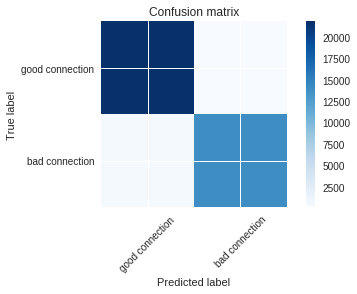

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     21938
           1       0.99      0.97      0.98     14459

   micro avg       0.98      0.98      0.98     36397
   macro avg       0.98      0.98      0.98     36397
weighted avg       0.98      0.98      0.98     36397



In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test
pred2 = y_pred_log
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_lr = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_lr))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,pred2))

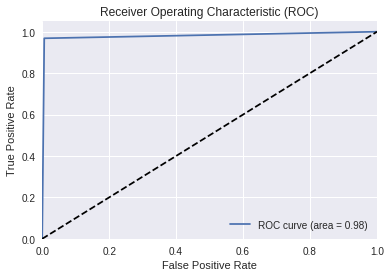

In [0]:
plot_roc(y_pred_log,y_test)

##RFE

In [0]:
# Feature Extraction with RFE
from sklearn.feature_selection import RFE
# feature extraction
rfe = RFE(logreg, 40)
fit = rfe.fit(x1, y1)

In [0]:
print("Num Features:", fit.n_features_)
print("Selected Features:",fit.support_,len(fit.support_))
print("Feature Ranking:", fit.ranking_,len(fit.ranking_))
lr_rank =  fit.ranking_
print(x1.shape)
print(np.array(x1.columns))

Num Features: 40
Selected Features: [ True False  True  True False  True  True  True False False  True  True
  True  True False  True  True False False  True False False False False
 False False  True  True  True False  True  True  True  True False  True
  True  True  True  True  True  True False False False False  True  True
 False False  True  True  True False  True False False False False  True
 False  True  True  True  True  True  True] 67
Feature Ranking: [ 1 15  1  1  3  1  1  1 13 14  1  1  1  1 16  1  1  6  4  1  9 20 28  2
 24 27  1  1  1 25  1  1  1  1  5  1  1  1  1  1  1  1 19 21  8 18  1  1
 10 22  1  1  1 26  1 11 23 12  7  1 17  1  1  1  1  1  1] 67
(145585, 67)
['wrong_fragment' 'hot' 'count' 'srv_count' 'serror_rate'
 'srv_serror_rate' 'rerror_rate' 'srv_rerror_rate' 'diff_srv_rate'
 'dst_host_count' 'dst_host_diff_srv_rate' 'dst_host_serror_rate'
 'dst_host_srv_serror_rate' 'dst_host_rerror_rate'
 'dst_host_srv_rerror_rate' 'protocol_type-icmp' 'protocol_type-tcp'
 's

In [0]:
#lr_rank.mean(axis=0)
def filter(n,lr_rank):
  list1 = [] 
  for i in range(0,len(lr_rank )):
    if(lr_rank[i]<=n):
      list1.append(i)
    else:
      pass
  print(list1)
  return list1

In [0]:
l = filter(1,lr_rank)

[0, 2, 3, 5, 6, 7, 10, 11, 12, 13, 15, 16, 19, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 46, 47, 50, 51, 52, 54, 59, 61, 62, 63, 64, 65, 66]


In [0]:
#final_dataset.drop(['connection_type'],axis=1)
df_lr = x1.iloc[:,l]

In [0]:
df_lr.shape

(145585, 40)

In [0]:
print(df_lr.columns)

Index(['wrong_fragment', 'count', 'srv_count', 'srv_serror_rate',
       'rerror_rate', 'srv_rerror_rate', 'dst_host_diff_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'protocol_type-icmp', 'protocol_type-tcp',
       'service-courier', 'service-eco_i', 'service-ecr_i', 'service-efs',
       'service-gopher', 'service-hostnames', 'service-http_443',
       'service-imap4', 'service-klogin', 'service-kshell', 'service-ldap',
       'service-link', 'service-login', 'service-mtp', 'service-name',
       'service-nnsp', 'service-nntp', 'service-private', 'service-remote_job',
       'service-rje', 'service-sql_net', 'service-uucp', 'service-vmnet',
       'service-whois', 'flag-REJ', 'flag-RSTO', 'flag-RSTR', 'flag-S0'],
      dtype='object')


In [0]:
x_lr = df_lr
y_lr = y1
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_lr, y_lr, test_size=0.25, random_state=42)

In [0]:
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg1 = LogisticRegression()

# fit the model with data
logreg1.fit(x_train1, y_train1)

# predict the response for new observations
y_pred_log1 = logreg1.predict(x_test1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#Results

Precision score: 0.983149633381547
Recall score: 0.9829656290353601
F1 score: 0.9829210865178606
[[21837   101]
 [  519 13940]]
Plot of Confusion Matrix


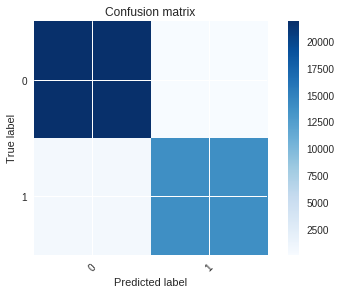

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     21938
           1       0.99      0.96      0.98     14459

   micro avg       0.98      0.98      0.98     36397
   macro avg       0.98      0.98      0.98     36397
weighted avg       0.98      0.98      0.98     36397



In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test1
pred2 = y_pred_log1
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_lr1))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,pred2))

In [0]:
plot_roc(y_pred_log1,y_test1)

#KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
print(knn) 

knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


Precision score: 0.993738504097874
Recall score: 0.993735747451713
F1 score: 0.9937330609847139
[[21860    78]
 [  150 14309]]
Plot of Confusion Matrix


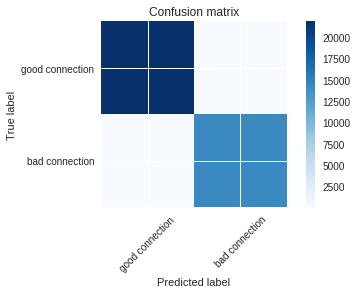

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21938
           1       0.99      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test
pred2 = y_pred_knn
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_knn = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_knn))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,pred2))

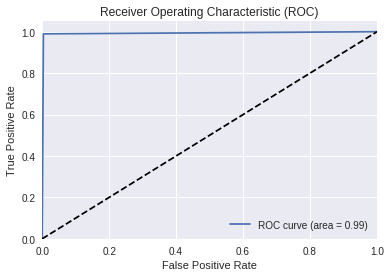

In [0]:
plot_roc(y_pred_knn,y_test)

##best k value

In [0]:
error_rate = []
for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

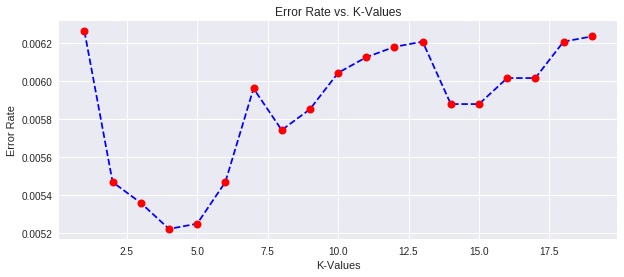

In [0]:
# Configure and plot error rate over k values
plt.figure(figsize=(10,4))
plt.plot(range(1,20), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=4)
print(knn2) 

knn2.fit(x_train, y_train)
y_pred_knn2 = knn2.predict(x_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')


Precision score: 0.9948074074143236
Recall score: 0.9947797895430942
F1 score: 0.9947749444064469
[[21920    18]
 [  172 14287]]
Plot of Confusion Matrix


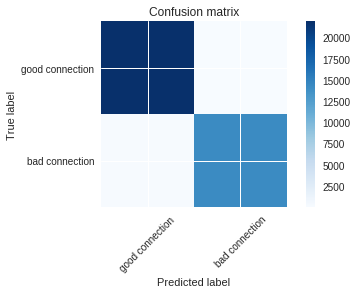

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21938
           1       1.00      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       1.00      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test
pred2 = y_pred_knn2
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_knn2 = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_knn2))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,pred2))

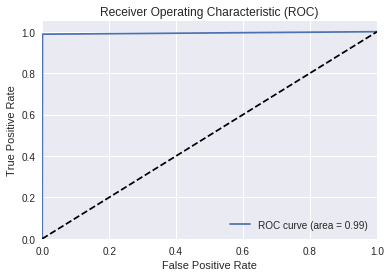

In [0]:
plot_roc(y_pred_knn2,y_test)

##Standard Scaler

In [0]:
#Import module to standardize the scale
from sklearn.preprocessing import StandardScaler
# Create instance (i.e. object) of the standard scaler
scaler = StandardScaler()
# Fit the object to all the data except the Target Class
# use the .drop() method to gather all features except Target Class
# axis -> argument refers to columns; a 0 would represent rows
scaler.fit(x1,y1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
# Use scaler object to conduct a transforms
scaled_features = scaler.transform(x1)
# Review the array of values generated from the scaled features process
scaled_features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[-0.08439415, -0.07020977, -0.66163875, ..., -0.06263948,
        -0.05410918, -0.63972356],
       [-0.08439415, -0.07020977, -0.66163875, ..., -0.06263948,
        -0.05410918, -0.63972356],
       [-0.08439415, -0.07020977, -0.68157181, ..., -0.06263948,
        -0.05410918, -0.63972356],
       ...,
       [-0.08439415, -0.07020977, -0.68157181, ..., -0.06263948,
        -0.05410918, -0.63972356],
       [-0.08439415, -0.07020977, -0.68157181, ..., -0.06263948,
        -0.05410918, -0.63972356],
       [-0.08439415, -0.07020977, -0.68157181, ..., -0.06263948,
        -0.05410918, -0.63972356]])

In [0]:
print (scaled_features.shape)
x1.shape

(145585, 67)


(145585, 67)

In [0]:
df_knn = pd.DataFrame(scaled_features,columns=x1.columns[:])
print(df_knn.columns)
df_knn.shape

Index(['wrong_fragment', 'hot', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'diff_srv_rate',
       'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'protocol_type-icmp', 'protocol_type-tcp',
       'service-Z39_50', 'service-bgp', 'service-courier', 'service-csnet_ns',
       'service-ctf', 'service-daytime', 'service-discard', 'service-domain',
       'service-echo', 'service-eco_i', 'service-ecr_i', 'service-efs',
       'service-exec', 'service-gopher', 'service-hostnames',
       'service-http_443', 'service-imap4', 'service-iso_tsap',
       'service-klogin', 'service-kshell', 'service-ldap', 'service-link',
       'service-login', 'service-mtp', 'service-name', 'service-netbios_dgm',
       'service-netbios_ns', 'service-netbios_ssn', 'service-netstat',
       'service-nnsp', 'service-nntp', 'service-pop_2', 'servic

(145585, 67)

In [0]:
y2 = final_dataset['connection_type']
x2 = df_knn
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.25, random_state=42)
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=4)
print(knn1) 

knn1.fit(x_train2, y_train2)
y_pred_knn = knn.predict(x_test2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')


Precision score: 0.9939615007172476
Recall score: 0.9939280709948622
F1 score: 0.9939217979937114
[[21913    25]
 [  196 14263]]
Plot of Confusion Matrix


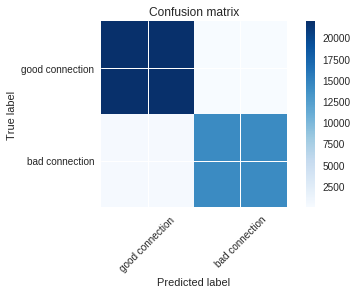

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21938
           1       1.00      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test2
pred2 = y_pred_knn
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_knn3 = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_knn3))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,pred2))

#SVM

In [0]:
#import, instantiate, fit and predict the data
from sklearn.svm import SVC

#svm.svc
svm_model1 = SVC(C=3)

svm_model1.fit(x_train, y_train)

y_pred_svm = svm_model1.predict(x_test)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#Result

Precision score: 0.9912417818980247
Recall score: 0.991235541390774
F1 score: 0.9912300338320205
[[21831   107]
 [  212 14247]]
Plot of Confusion Matrix


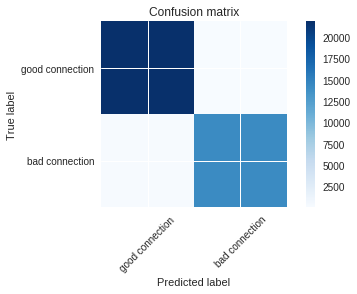

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21938
           1       0.99      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test
pred2 = y_pred_svm
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_svm = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_svm))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,pred2))

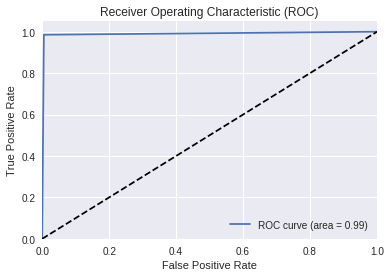

In [0]:
plot_roc(y_pred_svm,y_test)

##Best C value

In [0]:
from sklearn.svm import SVC
error_rate2 = []
for i in range(1,15):
    
    svm1 = SVC(C=i)
    svm1.fit(x_train, y_train)
    pred_i = svm1.predict(x_test)
    error_rate2.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

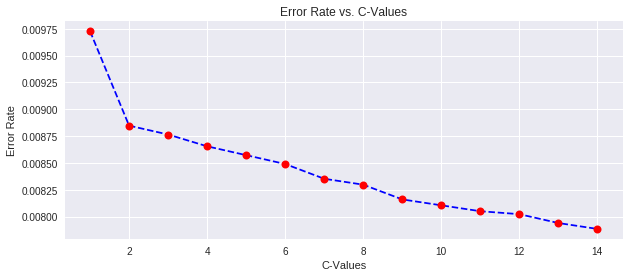

In [0]:
# Configure and plot error rate over C values
plt.figure(figsize=(10,4))
plt.plot(range(1,15), error_rate2, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. C-Values')
plt.xlabel('C-Values')
plt.ylabel('Error Rate')

In [0]:
#import, instantiate, fit and predict the data
from sklearn.svm import SVC
from sklearn import metrics
#svm svc
svm_model2 = SVC(C=14)

svm_model2.fit(x_train, y_train)

y_pred_svm2 = svm_model2.predict(x_test)
score_svm2 = metrics.f1_score(y_test, y_pred_svm2, average= "weighted")
print("F1 score: {}".format(score_svm2))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


F1 score: 0.9921092999356943


##Result

[[21852    86]
 [  201 14258]]
Plot of Confusion Matrix


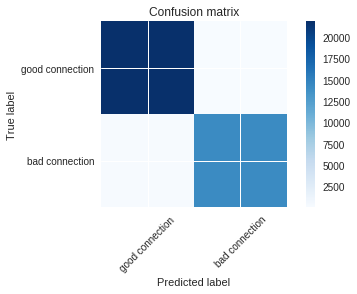

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn import svm, datasets
cm = confusion_matrix(y_test,y_pred_svm2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()

#GNB

In [0]:
from sklearn.naive_bayes import GaussianNB
clf1 = GaussianNB()
clf1.fit(x_train, y_train)
y_pred_gnb = clf1.predict(x_test)

#Result

Precision score: 0.9265566538007114
Recall score: 0.9178503722834299
F1 score: 0.9158705298699554
[[21865    73]
 [ 2917 11542]]
Plot of Confusion Matrix


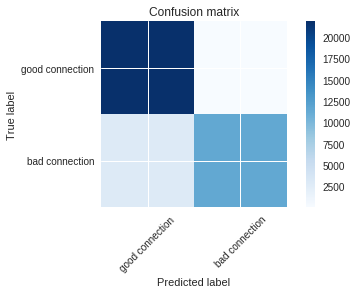

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     21938
           1       0.99      0.80      0.89     14459

   micro avg       0.92      0.92      0.92     36397
   macro avg       0.94      0.90      0.91     36397
weighted avg       0.93      0.92      0.92     36397



In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test
pred2 = y_pred_gnb
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,pred2))

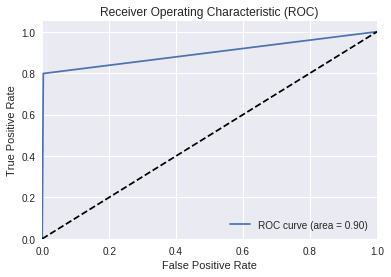

In [0]:
plot_roc(y_pred_gnb,y_test)

##Feature Importance

In [0]:
# Feature Importance with Extra Trees Classifier
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier

# feature extraction
model = ExtraTreesClassifier()
model.fit(x1, y1)
print(model.feature_importances_)
feature_imp = model.feature_importances_
feature_imp.mean()
#important = model.feature_importances_>feature_imp.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[1.40153395e-02 2.53000897e-02 1.74464092e-01 6.98133674e-03
 7.49374322e-02 3.56687858e-03 1.18457029e-02 1.96347579e-02
 5.40448655e-03 5.10278380e-02 1.27965651e-02 7.65574780e-02
 1.42082960e-01 2.04728413e-02 2.80896186e-02 6.91764149e-03
 4.59860521e-03 2.75864455e-07 6.87859172e-05 3.66180345e-07
 4.56065380e-05 5.99744405e-07 4.12186406e-06 1.27566632e-04
 1.43893096e-05 2.96373272e-06 7.91417198e-03 9.45513161e-03
 4.99352775e-05 1.57145564e-05 4.25979786e-05 2.49286325e-06
 1.12355510e-05 1.44100142e-04 3.75630202e-06 8.93645368e-06
 4.36314915e-06 1.42966195e-05 1.12167078e-05 5.20031248e-05
 1.21614595e-05 6.19967452e-06 0.00000000e+00 4.15895321e-05
 5.67251320e-13 6.84492032e-06 1.21181488e-05 1.32353232e-05
 0.00000000e+00 1.10064207e-05 1.40998389e-01 1.29809587e-04
 1.76615885e-05 2.21782364e-04 2.12805468e-04 7.00264283e-06
 7.34490880e-06 4.31596948e-07 3.69571631e-05 2.49724858e-05
 0.00000000e+00 3.36386014e-06 3.13677655e-06 1.48227094e-02
 1.77559486e-03 1.458135

0.014925373134328358

In [0]:
l_gb = filter(0.0149,feature_imp)
len(l_gb)

[0, 3, 5, 6, 8, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]


56

In [0]:
x1_gb = x1.iloc[:,l_gb]

In [0]:
print(x1_gb.shape)
y1_gb = y1
x_train2, x_test2, y_train2, y_test2 = train_test_split(x1_gb, y1_gb, test_size=0.25, random_state=42)

(145585, 56)


In [0]:
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
clf2.fit(x_train2, y_train2)
y_pred_gnb1 = clf2.predict(x_test2)

##Result

In [0]:
score_gnb1 = metrics.f1_score(y_test2, y_pred_gnb1, average= "weighted")
print("F1 score: {}".format(score_gnb1))

F1 score: 0.9111405862926503


#Fully Connected Nueral Network

In [0]:
x2,y2= to_xy(final_dataset, 'connection_type')
print(x2.shape,y2.shape)

(145585, 67) (145585, 2)


In [0]:
# Split into train/test
x_train01, x_test01, y_train01, y_test01 = train_test_split(x2, y2, test_size=0.25, random_state=42)

In [0]:
x2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
path = ""
save_path=""

##Model variations

In [0]:

checkpointer = ModelCheckpoint(filepath="neural_project3.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(25, input_dim=x2.shape[1], activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(y2.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)

    pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

    y_true = np.argmax(y_test01,axis=1)
    score = metrics.f1_score(y_true, pred2, average= "weighted")
    print("F1 score: {}".format(score))
    print(each,"ends")
    #loop ends
  
print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project3.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project3_1.hdf5"))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
0
Instructions for updating:
Use tf.cast instead.
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 4s - loss: 0.1021 - val_loss: 0.0444
Epoch 2/100
 - 4s - loss: 0.0377 - val_loss: 0.0388
Epoch 3/100
 - 4s - loss: 0.0325 - val_loss: 0.0282
Epoch 4/100
 - 4s - loss: 0.0305 - val_loss: 0.0275
Epoch 5/100
 - 4s - loss: 0.0293 - val_loss: 0.0265
Epoch 6/100
 - 4s - loss: 0.0284 - val_loss: 0.0252
Epoch 7/100
 - 4s - loss: 0.0277 - val_loss: 0.0247
Epoch 8/100
 - 4s - loss: 0.0270 - val_loss: 0.0235
Epoch 9/100
 - 4s - loss: 0.0265 - val_loss: 0.0230
Epoch 10/100
 - 4s - loss: 0.0259 - val_loss: 0.0227
Epoch 11/100
 - 4s - loss: 0.0256 - val_loss: 0.0255
Epoch 12/100
 - 4s - loss: 0.0250 - val_loss: 0.0233
Epoch 13/100
 - 4s - loss: 0.0248 - val_loss: 0.0215
Epoch 14/100
 - 4s - loss: 0.0248 - val_loss: 0.0223
Epoch 15/100
 - 4s - loss: 0.0244 - val_loss: 0.0214
Epoch 16/100
 - 4s - loss: 0.0242 - val_l

In [0]:

checkpointer = ModelCheckpoint(filepath="neural_project3_2.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(20, input_dim=x2.shape[1], activation='sigmoid'))
    model.add(Dense(10,activation='sigmoid'))
    model.add(Dense(5,activation='sigmoid'))
    model.add(Dense(y2.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)

    pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

    y_true = np.argmax(y_test01,axis=1)
    score = metrics.f1_score(y_true, pred2, average= "weighted")
    print("F1 score: {}".format(score))
    print(each,"ends")
    #loop ends
  
#print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project3.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project3_2.hdf5"))

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 5s - loss: 0.6633 - val_loss: 0.6487
Epoch 2/100
 - 4s - loss: 0.5190 - val_loss: 0.2539
Epoch 3/100
 - 4s - loss: 0.1499 - val_loss: 0.1122
Epoch 4/100
 - 4s - loss: 0.1028 - val_loss: 0.0978
Epoch 5/100
 - 4s - loss: 0.0936 - val_loss: 0.0917
Epoch 6/100
 - 4s - loss: 0.0889 - val_loss: 0.0875
Epoch 7/100
 - 4s - loss: 0.0848 - val_loss: 0.0826
Epoch 8/100
 - 4s - loss: 0.0786 - val_loss: 0.0737
Epoch 9/100
 - 4s - loss: 0.0694 - val_loss: 0.0643
Epoch 10/100
 - 4s - loss: 0.0623 - val_loss: 0.0578
Epoch 11/100
 - 4s - loss: 0.0568 - val_loss: 0.0527
Epoch 12/100
 - 4s - loss: 0.0528 - val_loss: 0.0493
Epoch 13/100
 - 4s - loss: 0.0502 - val_loss: 0.0470
Epoch 14/100
 - 4s - loss: 0.0484 - val_loss: 0.0455
Epoch 15/100
 - 4s - loss: 0.0470 - val_loss: 0.0442
Epoch 16/100
 - 4s - loss: 0.0458 - val_loss: 0.0431
Epoch 17/100
 - 4s - loss: 0.0448 - val_loss: 0.0422
Epoch 18/100
 - 4s - loss: 0.0438 - val_loss: 0.0413
Ep

In [0]:
checkpointer = ModelCheckpoint(filepath="neural_project3_3.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(30, input_dim=x2.shape[1], activation='tanh'))
    model.add(Dense(20,activation='tanh'))
    model.add(Dense(10,activation='tanh'))
    model.add(Dense(y2.shape[1],activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)

    pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

    y_true = np.argmax(y_test01,axis=1)
    score = metrics.f1_score(y_true, pred2, average= "weighted")
    print("F1 score: {}".format(score))
    print(each,"ends")
    #loop ends
#print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project3.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project3_3.hdf5"))

Instructions for updating:
Colocations handled automatically by placer.
0
Instructions for updating:
Use tf.cast instead.
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 4s - loss: 0.0791 - val_loss: 0.0479
Epoch 2/100
 - 3s - loss: 0.0452 - val_loss: 0.0401
Epoch 3/100
 - 3s - loss: 0.0402 - val_loss: 0.0370
Epoch 4/100
 - 3s - loss: 0.0379 - val_loss: 0.0349
Epoch 5/100
 - 3s - loss: 0.0364 - val_loss: 0.0334
Epoch 6/100
 - 3s - loss: 0.0352 - val_loss: 0.0323
Epoch 7/100
 - 3s - loss: 0.0340 - val_loss: 0.0315
Epoch 8/100
 - 3s - loss: 0.0332 - val_loss: 0.0304
Epoch 9/100
 - 3s - loss: 0.0321 - val_loss: 0.0303
Epoch 10/100
 - 3s - loss: 0.0314 - val_loss: 0.0291
Epoch 11/100
 - 3s - loss: 0.0308 - val_loss: 0.0285
Epoch 12/100
 - 3s - loss: 0.0303 - val_loss: 0.0283
Epoch 13/100
 - 4s - loss: 0.0299 - val_loss: 0.0278
Epoch 14/100
 - 4s - loss: 0.0295 - val_loss: 0.0276
Epoch 15/100
 - 4s - loss: 0.0291 - val_loss: 0.0289
Epoch 16/100
 - 3s - loss: 0.0287 - val_l

##best Nueral Network model

In [0]:
checkpointer = ModelCheckpoint(filepath="neural_project3.hdf5", verbose=0, save_best_only=True) # save best model
Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

for i in range(5):
  print(i)
  model = Sequential()
  model.add(Dense(25, input_dim=x2.shape[1], activation='relu'))
  model.add(Dropout(0.01))
  model.add(Dense(25,activation='relu'))
  model.add(Dense(25,activation='relu'))
  model.add(Dense(25,activation='relu'))
  model.add(Dropout(0.2)) 
  model.add(Dense(y2.shape[1],activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

  model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred2 = model.predict(x_test01)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test01,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  #loop ends
  
print('Training finished')  
print()

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 10s - loss: 0.0439 - acc: 0.9886 - val_loss: 0.0300 - val_acc: 0.9906
Epoch 2/100
 - 7s - loss: 0.0399 - acc: 0.9892 - val_loss: 0.0273 - val_acc: 0.9912
Epoch 3/100
 - 7s - loss: 0.0335 - acc: 0.9904 - val_loss: 0.0381 - val_acc: 0.9864
Epoch 4/100
 - 7s - loss: 0.0384 - acc: 0.9901 - val_loss: 0.0302 - val_acc: 0.9919
Epoch 5/100
 - 7s - loss: 0.0386 - acc: 0.9903 - val_loss: 0.0353 - val_acc: 0.9908
Epoch 6/100
 - 7s - loss: 0.0453 - acc: 0.9892 - val_loss: 0.0498 - val_acc: 0.9875
Epoch 7/100
 - 6s - loss: 0.0497 - acc: 0.9876 - val_loss: 0.0693 - val_acc: 0.9898
Epoch 00007: early stopping
F1 score: 0.9897538865138271
1
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 9s - loss: 0.0872 - acc: 0.9861 - val_loss: 0.0291 - val_acc: 0.9918
Epoch 2/100
 - 7s - loss: 0.0361 - acc: 0.9895 - val_loss: 0.0256 - val_acc: 0.9921
Epoch 3/100
 - 7s - loss: 0.0341 - acc: 0.9900 - val_loss: 0.0246 - val_acc: 0.9

Precision score: 0.9937326496305225
Recall score: 0.9937082726598346
F1 score: 0.9937025492122233
Log loss score: 0.21730942052186605
[[21899    39]
 [  190 14269]]
Plot of Confusion Matrix


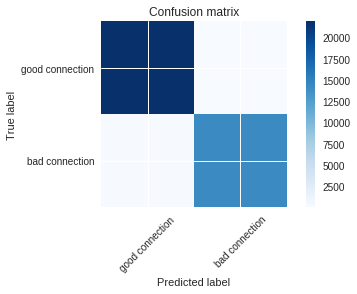

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21938
           1       1.00      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
#the bset classification model for 5 stars
#loading the best saved model
from keras.models import load_model
model2 = load_model(os.path.join(save_path,"neural_project3.hdf5"))
predc = model2.predict(x_test01)
predc = np.argmax(predc,axis=1)
y_true = np.argmax(y_test01,axis=1)
score = metrics.precision_score(y_true, predc, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predc, average= "weighted")
print("Recall score: {}".format(score))
score_nn1 = metrics.f1_score(y_true, predc, average= "weighted")
print("F1 score: {}".format(score_nn1))
score = metrics.log_loss(y_true, predc) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predc)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,predc))

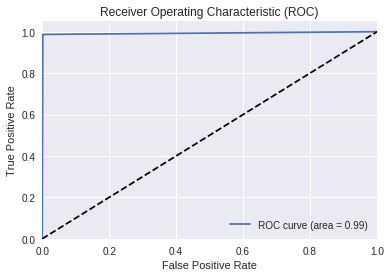

In [0]:
plot_roc(predc,y_true)

##feature importance

In [0]:
from sklearn import metrics
import scipy as sp
import numpy as np
import math
from sklearn import metrics

def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]
    print (len(errors))
    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

In [0]:
names = list(final_dataset.columns) # x+y column names
names.remove('connection_type')
rank = perturbation_rank(model, x2, y2, names, False)
rank

67


name     error  importance
0   dst_host_srv_serror_rate  0.820709  1.000000  
1   count                     0.570889  0.695605  
2   wrong_fragment            0.193484  0.235752  
3   service-private           0.164479  0.200411  
4   flag-S0                   0.108442  0.132132  
5   srv_count                 0.087871  0.107068  
6   hot                       0.081466  0.099263  
7   dst_host_count            0.072727  0.088615  
8   dst_host_serror_rate      0.071365  0.086955  
9   protocol_type-icmp        0.062210  0.075800  
10  rerror_rate               0.053394  0.065059  
11  dst_host_srv_rerror_rate  0.050622  0.061681  
12  flag-REJ                  0.044375  0.054069  
13  dst_host_rerror_rate      0.043417  0.052901  
14  service-ecr_i             0.041097  0.050074  
15  dst_host_diff_srv_rate    0.040632  0.049508  
16  serror_rate               0.038735  0.047197  
17  srv_serror_rate           0.034366  0.041874  
18  srv_rerror_rate           0.034037  0.041472  
19  service-imap4             0.033820  0.041209  
20  service-eco_i             0.033783  0.041163  
21  diff_srv_rate             0.033327  0.040608  
22  flag-RSTR                 0.032448  0.039537  
23  flag-RSTO                 0.031862  0.038822  
24  service-efs               0.031543  0.038434  
25  service-nntp              0.031499  0.038380  
26  service-login             0.031454  0.038326  
27  service-exec              0.031445  0.038314  
28  service-shell             0.031391  0.038248  
29  service-courier           0.031353  0.038202  
..              ...                ...       ...  
37  service-link              0.031321  0.038163  
38  service-ldap              0.031312  0.038152  
39  service-kshell            0.031305  0.038144  
40  service-whois             0.031305  0.038144  
41  service-klogin            0.031305  0.038144  
42  service-name              0.031302  0.038140  
43  service-http_443          0.031301  0.038140  
44  service-Z39_50            0.031296  0.038133  
45  service-domain            0.031294  0.038130  
46  service-sunrpc            0.031293  0.038130  
47  service-vmnet             0.031293  0.038130  
48  service-printer           0.031288  0.038123  
49  service-sql_net           0.031287  0.038122  
50  service-netbios_ssn       0.031287  0.038122  
51  service-pop_2             0.031286  0.038121  
52  service-csnet_ns          0.031285  0.038120  
53  service-supdup            0.031285  0.038119  
54  service-systat            0.031284  0.038119  
55  service-discard           0.031284  0.038118  
56  service-netstat           0.031283  0.038117  
57  service-iso_tsap          0.031281  0.038114  
58  service-uucp              0.031281  0.038114  
59  service-netbios_dgm       0.031279  0.038112  
60  service-ssh               0.031279  0.038112  
61  service-daytime           0.031279  0.038112  
62  service-echo              0.031278  0.038111  
63  service-ctf               0.031278  0.038110  
64  service-uucp_path         0.031277  0.038110  
65  service-netbios_ns        0.031275  0.038107  
66  protocol_type-tcp         0.028813  0.035107  

[67 rows x 3 columns]

In [0]:
rank['importance'].describe()

count    67.000000
mean     0.074995 
std      0.143424 
min      0.035107 
25%      0.038122 
50%      0.038173 
75%      0.044535 
max      1.000000 
Name: importance, dtype: float64

In [0]:
l_nn = filter( 0.044535 ,rank['importance'])
len(l_nn)

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]


50

In [0]:
x_nn = x2[:,l_nn]
print(x_nn.shape)
y_nn = y2
# Split into train/test
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(x_nn, y_nn, test_size=0.25, random_state=42)

(145585, 50)


In [0]:
checkpointer = ModelCheckpoint(filepath="neural_project3.hdf5", verbose=0, save_best_only=True) # save best model
Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

for i in range(5):
  print(i)
  model = Sequential()
  model.add(Dense(25, input_dim=x2.shape[1], activation='relu'))
  model.add(Dropout(0.01))
  model.add(Dense(25,activation='relu'))
  model.add(Dense(25,activation='relu'))
  model.add(Dense(25,activation='relu'))
  model.add(Dropout(0.2)) 
  model.add(Dense(y2.shape[1],activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

  model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred2 = model.predict(x_test01)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test01,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  #loop ends
  
print('Training finished')  
print()

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 10s - loss: 0.0431 - acc: 0.9890 - val_loss: 0.0317 - val_acc: 0.9924
Epoch 2/100
 - 7s - loss: 0.0358 - acc: 0.9909 - val_loss: 0.0298 - val_acc: 0.9932
Epoch 3/100
 - 7s - loss: 0.0296 - acc: 0.9920 - val_loss: 0.0265 - val_acc: 0.9903
Epoch 4/100
 - 7s - loss: 0.0335 - acc: 0.9914 - val_loss: 0.0211 - val_acc: 0.9935
Epoch 5/100
 - 7s - loss: 0.0271 - acc: 0.9926 - val_loss: 0.0212 - val_acc: 0.9929
Epoch 6/100
 - 7s - loss: 0.0284 - acc: 0.9924 - val_loss: 0.0252 - val_acc: 0.9940
Epoch 7/100
 - 7s - loss: 0.0281 - acc: 0.9925 - val_loss: 0.0226 - val_acc: 0.9937
Epoch 8/100
 - 7s - loss: 0.0421 - acc: 0.9906 - val_loss: 0.0266 - val_acc: 0.9938
Epoch 9/100
 - 7s - loss: 0.0286 - acc: 0.9921 - val_loss: 0.0261 - val_acc: 0.9937
Epoch 00009: early stopping
F1 score: 0.9937037060012337
1
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 10s - loss: 0.0481 - acc: 0.9872 - val_loss: 0.0341 - val_acc: 0.

Precision score: 0.9935140482694839
Recall score: 0.993488474324807
F1 score: 0.993482390539483
Log loss score: 0.22490103000490438
[[21897    41]
 [  196 14263]]
Plot of Confusion Matrix


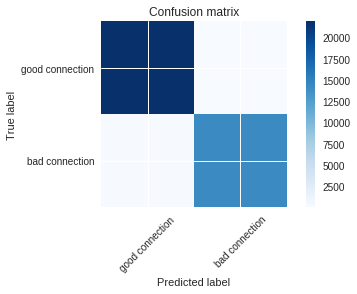

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21938
           1       1.00      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:

#loading the best saved model
from keras.models import load_model
model2 = load_model(os.path.join(save_path,"neural_project3.hdf5"))
predc = model2.predict(x_test01)
predc = np.argmax(predc,axis=1)
y_true = np.argmax(y_test01,axis=1)
score = metrics.precision_score(y_true, predc, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predc, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, predc, average= "weighted")
print("F1 score: {}".format(score))
score = metrics.log_loss(y_true, predc) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predc)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,predc))

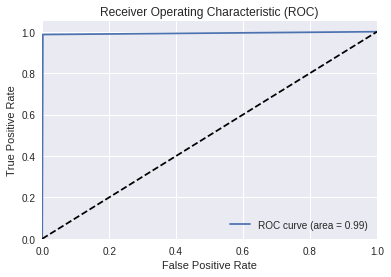

In [0]:
plot_roc(predc,y_true)

#CNN

In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import time

In [0]:
print(x2.shape,y2.shape)

(145585, 67) (145585, 2)


In [0]:
# process the data to fit in a keras CNN properly， input data needs to be (N, X, Y, C) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size

x3 = x2.reshape((145585, 1, 67, 1))

# output labels should be one-hot vectors - ie,
# 0 -> [0, 0, 1]
# 1 -> [0, 1, 0]
# 2 -> [1, 0, 0]
# this operation changes the shape of y from (10000,1) to (10000, 3)
# Converts a class vector (integers) to binary class matrix.  
y3 = y2 #alrady one hot encoded
print(x3.shape,y3.shape)

(145585, 1, 67, 1) (145585, 2)


In [0]:
# split your data to training and test
x_train2, x_test2, y_train2, y_test2 = train_test_split(x3, y3, test_size=0.25, random_state=42)

In [0]:
print("x_train",x_train2.shape)
print("y_train",y_train2.shape)
print("x_test",x_test2.shape)
print("y_test",y_test2.shape)

x_train (109188, 1, 67, 1)
y_train (109188, 2)
x_test (36397, 1, 67, 1)
y_test (36397, 2)


In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 67, 1)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(67, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Dropout(0.25))    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(y3.shape[1], activation="softmax"))

In [0]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 65, 64)         256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 32, 64)         0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 1, 32, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 30, 128)        24704     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 15, 128)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 1, 15, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
__________

In [0]:
SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="cnn_project3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(1):
  
  print(i)
  
  cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])


  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  cnn.fit(x_train2, y_train2,     
          batch_size=128,
          epochs=100,
          verbose=2,
          callbacks=[monitor,checkpointer],
          validation_data=(x_test2, y_test2))
   
  pred2 = cnn.predict(x_test2)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test2,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  
print('Training finished...Loading the best model')  
print()
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
#cnn.save(os.path.join(save_path,"cnn_project3.hdf5"))         

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 81s - loss: 0.0523 - acc: 0.9854 - val_loss: 0.0329 - val_acc: 0.9914
Epoch 2/100
 - 76s - loss: 0.0358 - acc: 0.9903 - val_loss: 0.0256 - val_acc: 0.9934
Epoch 3/100
 - 77s - loss: 0.0311 - acc: 0.9918 - val_loss: 0.0225 - val_acc: 0.9935
Epoch 4/100
 - 77s - loss: 0.0286 - acc: 0.9922 - val_loss: 0.0227 - val_acc: 0.9939
Epoch 5/100
 - 77s - loss: 0.0275 - acc: 0.9926 - val_loss: 0.0221 - val_acc: 0.9928
Epoch 6/100
 - 76s - loss: 0.0265 - acc: 0.9925 - val_loss: 0.0212 - val_acc: 0.9937
Epoch 7/100
 - 77s - loss: 0.0249 - acc: 0.9929 - val_loss: 0.0209 - val_acc: 0.9938
Epoch 8/100
 - 76s - loss: 0.0248 - acc: 0.9930 - val_loss: 0.0242 - val_acc: 0.9940
Epoch 9/100
 - 76s - loss: 0.0245 - acc: 0.9929 - val_loss: 0.0196 - val_acc: 0.9939
Epoch 10/100
 - 76s - loss: 0.0239 - acc: 0.9930 - val_loss: 0.0194 - val_acc: 0.9939
Epoch 11/100
 - 77s - loss: 0.0226 - acc: 0.9934 - val_loss: 0.0198 - val_acc: 0.9938
Epoch 12/1

In [0]:
# evaluate() computes the loss and accuracy
score_CNN = cnn.evaluate(x_test2, y_test2, verbose=0)
print('Test loss: {}'.format(score_CNN[0]))
print('Test accuracy: {}'.format(score_CNN[1]))

Test loss: 0.01918541707273211
Test accuracy: 0.9941203945380114


Precision score: 0.9943498309261105
Recall score: 0.9943127180811605
F1 score: 0.9943066310912189
Log loss score: 0.19643208802121054
[[21923    15]
 [  192 14267]]
Plot of Confusion Matrix


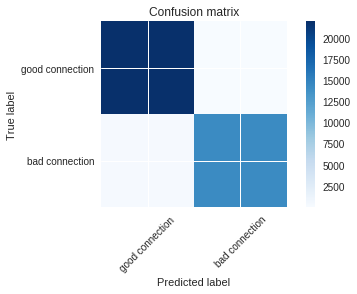

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21938
           1       1.00      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       1.00      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
from sklearn import metrics
from keras.models import load_model
model3 = load_model(os.path.join(save_path,"cnn_project3.hdf5"))
predcn = model3.predict(x_test2)
predcn = np.argmax(predcn,axis=1)
y_true = np.argmax(y_test2,axis=1)
score = metrics.precision_score(y_true, predcn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predcn, average= "weighted")
print("Recall score: {}".format(score))
score_cn1 = metrics.f1_score(y_true, predcn, average= "weighted")
print("F1 score: {}".format(score_cn1))
score = metrics.log_loss(y_true, predcn) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predcn)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,predcn))

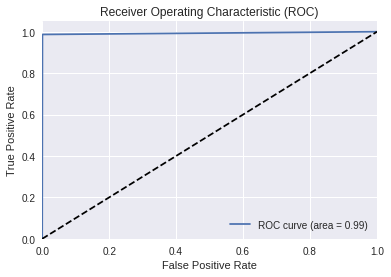

In [0]:
plot_roc(predcn,y_true)

## l1 l2 regularization technique with tensorflow

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import regularizers
# define a CNN

cnn1 = Sequential()
cnn1.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 67, 1)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(67, 1)))

cnn1.add(MaxPooling2D(pool_size=(1,2)))
cnn1.add(Dropout(0.25))
cnn1.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu', 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01)))
cnn1.add(MaxPooling2D(pool_size=(1,2)))
cnn1.add(Dropout(0.25))    
    
cnn1.add(Flatten())
cnn1.add(Dense(1024, activation="relu",
        kernel_regularizer=regularizers.l1(0.01),
         activity_regularizer=regularizers.l2(0.01)))
cnn1.add(Dropout(0.25))
cnn1.add(Dense(y3.shape[1], activation="softmax"))

In [0]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 65, 64)         256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 32, 64)         0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 1, 32, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 30, 128)        24704     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 15, 128)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 1, 15, 128)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1920)              0         
__________

In [0]:
SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

start_time = time.time()
#checkpointer = ModelCheckpoint(filepath="cnn1_project3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(1):
  
  print(i)
  
  cnn1.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])


  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  cnn1.fit(x_train2, y_train2,     
          batch_size=128,
          epochs=100,
          verbose=2,
          callbacks=[monitor],
          validation_data=(x_test2, y_test2))
   
  pred2 = cnn1.predict(x_test2)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test2,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  
print('Training finished...Loading the best model')  
print()
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
cnn.save(os.path.join(save_path,"cnn1_project3.hdf5"))         

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 90s - loss: 13.1566 - acc: 0.6054 - val_loss: 3.1459 - val_acc: 0.6027
Epoch 2/100
 - 86s - loss: 3.1147 - acc: 0.6035 - val_loss: 3.0842 - val_acc: 0.6027
Epoch 3/100
 - 85s - loss: 3.1148 - acc: 0.6035 - val_loss: 3.1448 - val_acc: 0.6027
Epoch 4/100
 - 85s - loss: 3.1151 - acc: 0.6035 - val_loss: 3.1143 - val_acc: 0.6027
Epoch 5/100
 - 85s - loss: 3.1147 - acc: 0.6035 - val_loss: 3.1011 - val_acc: 0.6027
Epoch 6/100
 - 86s - loss: 3.1149 - acc: 0.6035 - val_loss: 3.1449 - val_acc: 0.6027
Epoch 7/100
 - 85s - loss: 3.1147 - acc: 0.6035 - val_loss: 3.0992 - val_acc: 0.6027
Epoch 00007: early stopping
F1 score: 0.45334545813066257
Training finished...Loading the best model

Elapsed time: 0:10:10.38


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import regularizers
# define a CNN

cnn1 = Sequential()
cnn1.add(Conv2D(64, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 67, 1)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(67, 1)))

cnn1.add(MaxPooling2D(pool_size=(1,2)))
cnn1.add(Dropout(0.1))
cnn1.add(Conv2D(128, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu', 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01)))
cnn1.add(MaxPooling2D(pool_size=(1,2)))
cnn1.add(Dropout(0.1))    
    
cnn1.add(Flatten())
cnn1.add(Dense(1024, activation="relu"))
cnn1.add(Dropout(0.2))
cnn1.add(Dense(y3.shape[1], activation="softmax"))
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1, 67, 64)         128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 33, 64)         0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 1, 33, 64)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 33, 128)        8320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 16, 128)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 1, 16, 128)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
__________

In [0]:
SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="cnn1_project3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(1):
  
  print(i)
  
  cnn1.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])


  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  cnn1.fit(x_train2, y_train2,     
          batch_size=128,
          epochs=100,
          verbose=2,
          callbacks=[monitor,checkpointer],
          validation_data=(x_test2, y_test2))
   
  pred2 = cnn1.predict(x_test2)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test2,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  
print('Training finished...Loading the best model')  
print()
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
cnn.save(os.path.join(save_path,"cnn1_project3.hdf5"))         

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 84s - loss: 1.2793 - acc: 0.9776 - val_loss: 0.1270 - val_acc: 0.9834
Epoch 2/100
 - 80s - loss: 0.0918 - acc: 0.9833 - val_loss: 0.0761 - val_acc: 0.9816
Epoch 3/100
 - 79s - loss: 0.0755 - acc: 0.9844 - val_loss: 0.0783 - val_acc: 0.9788
Epoch 4/100
 - 79s - loss: 0.0694 - acc: 0.9860 - val_loss: 0.0798 - val_acc: 0.9842
Epoch 5/100
 - 79s - loss: 0.0678 - acc: 0.9867 - val_loss: 0.0577 - val_acc: 0.9902
Epoch 6/100
 - 80s - loss: 0.0650 - acc: 0.9873 - val_loss: 0.1187 - val_acc: 0.9673
Epoch 7/100
 - 79s - loss: 0.0682 - acc: 0.9866 - val_loss: 0.0557 - val_acc: 0.9908
Epoch 8/100
 - 79s - loss: 0.0649 - acc: 0.9869 - val_loss: 0.0571 - val_acc: 0.9909
Epoch 9/100
 - 79s - loss: 0.0627 - acc: 0.9869 - val_loss: 0.0587 - val_acc: 0.9897
Epoch 10/100
 - 80s - loss: 0.0630 - acc: 0.9875 - val_loss: 0.0535 - val_acc: 0.9909
Epoch 11/100
 - 79s - loss: 0.0602 - acc: 0.9884 - val_loss: 0.0524 - val_acc: 0.9909
Epoch 12/1

Precision score: 0.9941566017405826
Recall score: 0.9941203945380114
F1 score: 0.9941141381535039
Log loss score: 0.20307479574860823
[[21919    19]
 [  195 14264]]
Plot of Confusion Matrix


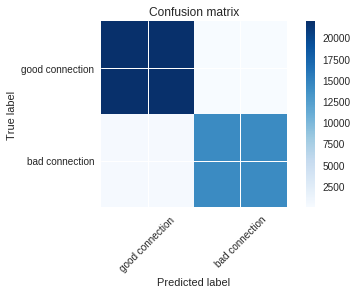

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21938
           1       1.00      0.99      0.99     14459

   micro avg       0.99      0.99      0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
from sklearn import metrics
from keras.models import load_model
model3 = load_model(os.path.join(save_path,"cnn1_project3.hdf5"))
predcn = model3.predict(x_test2)
predcn = np.argmax(predcn,axis=1)
y_true = np.argmax(y_test2,axis=1)
score = metrics.precision_score(y_true, predcn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predcn, average= "weighted")
print("Recall score: {}".format(score))
score_cn2 = metrics.f1_score(y_true, predcn, average= "weighted")
print("F1 score: {}".format(score_cn2))
score = metrics.log_loss(y_true, predcn) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predcn)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['good connection','bad connection'])
plt.show()
print(classification_report(y_true,predcn))

#Proability Calibaration Curve

Logistic:
	Brier: 0.016
	Precision: 0.992
	Recall: 0.960
	F1: 0.976

Naive Bayes:
	Brier: 0.087
	Precision: 0.983
	Recall: 0.794
	F1: 0.879

Naive Bayes + Isotonic:
	Brier: 0.023
	Precision: 0.964
	Recall: 0.968
	F1: 0.966

Naive Bayes + Sigmoid:
	Brier: 0.075
	Precision: 0.967
	Recall: 0.812
	F1: 0.883

Logistic:
	Brier: 0.016
	Precision: 0.992
	Recall: 0.960
	F1: 0.976



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC:
	Brier: 0.093
	Precision: 0.990
	Recall: 0.964
	F1: 0.977



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC + Isotonic:
	Brier: 0.012
	Precision: 0.982
	Recall: 0.971
	F1: 0.976



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC + Sigmoid:
	Brier: 0.015
	Precision: 0.989
	Recall: 0.963
	F1: 0.976

Logistic:
	Brier: 0.016
	Precision: 0.992
	Recall: 0.960
	F1: 0.976

KNN:
	Brier: 0.012
	Precision: 0.991
	Recall: 0.973
	F1: 0.982

KNN + Isotonic:
	Brier: 0.013
	Precision: 0.991
	Recall: 0.966
	F1: 0.978

KNN + Sigmoid:
	Brier: 0.014
	Precision: 0.988
	Recall: 0.975
	F1: 0.981



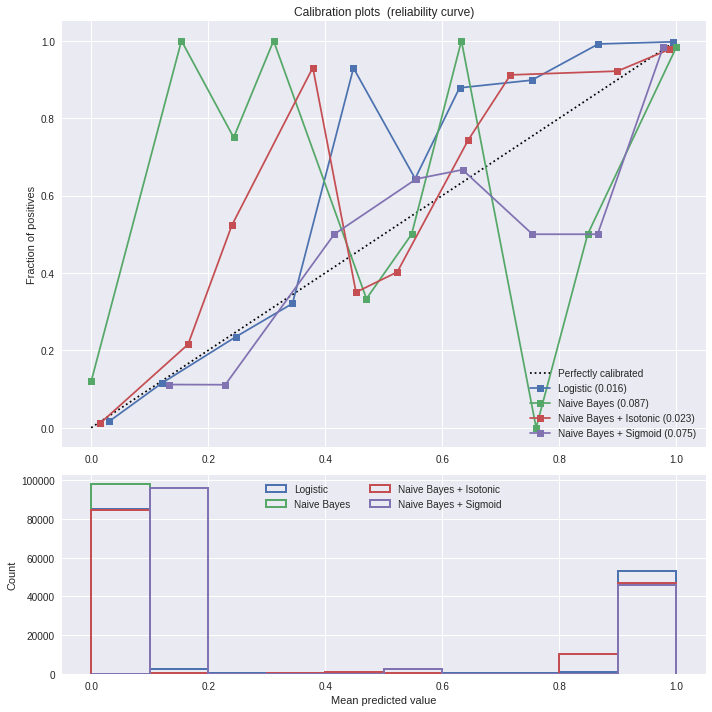

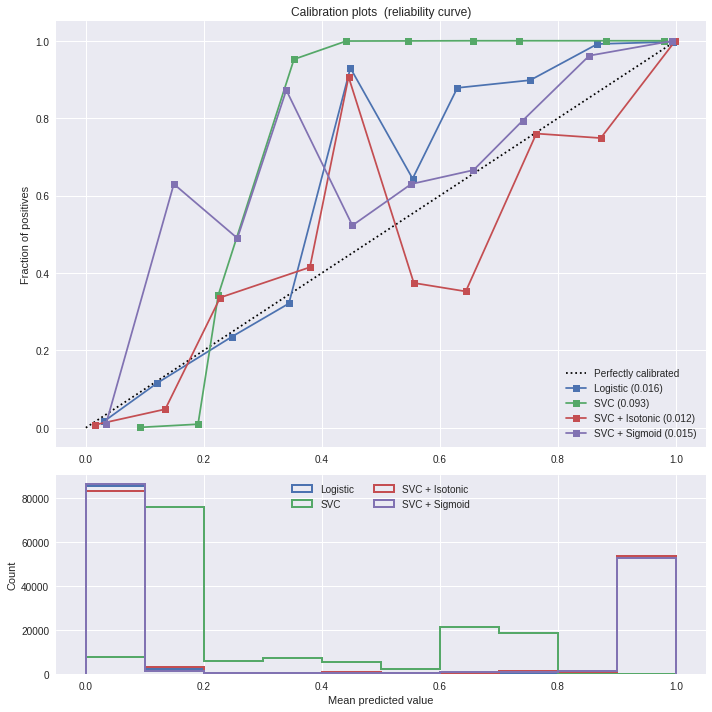

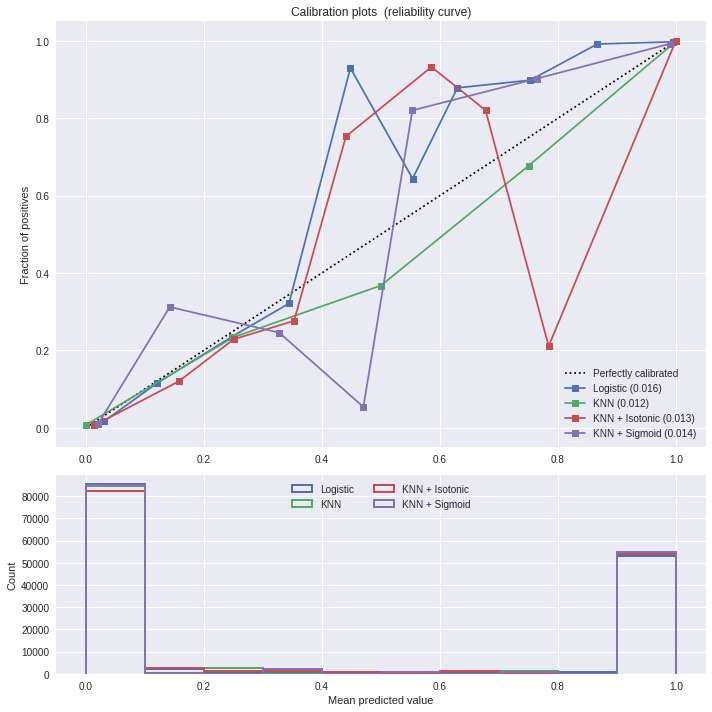

In [0]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# Create dataset of classification task with many redundant and few
# informative features
#x, y = dataset.make_classification(n_samples=145585, n_features=68,
                                    #n_informative=2, n_redundant=12,
                                    #random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(x1, y1, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(Y_test, prob_pos, pos_label=y1.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(Y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(Y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(Y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(Y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(C=3), "SVC", 2)
plot_calibration_curve(KNeighborsClassifier(n_neighbors=4), "KNN", 3)

plt.show()

#Multi classification

##one hot encoding & normalization

In [0]:
df2.shape

(145585, 40)

In [0]:
#one hot encoding of protocol type, service and flag columns
encode_text_dummy(df2, 'protocol_type')
encode_text_dummy(df2, 'service')
encode_text_dummy(df2, 'flag')
df2.shape

(145585, 117)

In [0]:
encode_numeric_zscore(df2,'duration')
encode_numeric_zscore(df2,'src_bytes')
encode_numeric_zscore(df2,'dst_bytes')
encode_numeric_zscore(df2,'wrong_fragment')
encode_numeric_zscore(df2,'urgent')
encode_numeric_zscore(df2,'hot')
encode_numeric_zscore(df2,'num_failed_logins')
encode_numeric_zscore(df2,'num_compromised')
encode_numeric_zscore(df2,'num_root')
encode_numeric_zscore(df2,'num_file_creations')
encode_numeric_zscore(df2,'num_shells' )
encode_numeric_zscore(df2,'num_access_files')
encode_numeric_zscore(df2,'count')
encode_numeric_zscore(df2,'srv_count')
encode_numeric_zscore(df2,'dst_host_count')
encode_numeric_zscore(df2,'dst_host_srv_count')

##multi classifying

In [0]:
dos = ['back.', 'land.', 'neptune.', 'pod.', 'smurf.', 'teardrop.']
probe = ['ipsweep.', 'nmap.', 'postsweep.','satan.']
U2R = ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.']
R2L = ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.', 'phf.', 'spy.', 'warezclient.', 'warezmaster.']

In [0]:
def multiclassify(row):
  dos = ['back.', 'land.', 'neptune.', 'pod.', 'smurf.', 'teardrop.']
  probe = ['ipsweep.', 'nmap.', 'postsweep.','satan.']
  U2R = ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.']
  R2L = ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.', 'phf.', 'spy.', 'warezclient.', 'warezmaster.']
  if row['outcome'] in dos:
    return '1'
  elif row['outcome'] in probe:
    return '2'
  elif row['outcome'] in U2R:
    return '3'
  elif row['outcome'] == 'normal.' :
    return '0'
  else:
    return '4'
    
  

In [0]:
df2['connection']= df2.apply(lambda x: multiclassify(x),axis=1)

In [0]:
df2.connection.value_counts()

0    87831
1    54572
2    1715 
4    1415 
3    52   
Name: connection, dtype: int64

In [0]:
df2.dtypes

duration                  float64
src_bytes                 float64
dst_bytes                 float64
land                      int64  
wrong_fragment            float64
urgent                    float64
hot                       float64
num_failed_logins         float64
logged_in                 int64  
num_compromised           float64
root_shell                int64  
su_attempted              int64  
num_root                  float64
num_file_creations        float64
num_shells                float64
num_access_files          float64
is_guest_login            int64  
count                     float64
srv_count                 float64
serror_rate               float64
srv_serror_rate           float64
rerror_rate               float64
srv_rerror_rate           float64
same_srv_rate             float64
diff_srv_rate             float64
srv_diff_host_rate        float64
dst_host_count            float64
dst_host_srv_count        float64
dst_host_same_srv_rate    float64
dst_host_diff_

In [0]:
df2.shape

(145585, 118)

In [0]:
df2.drop('outcome',1,inplace=True)

In [0]:
print(df2.columns)


Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag-RSTO', 'flag-RSTOS0', 'flag-RSTR', 'flag-S0', 'flag-S1',
       'flag-S2', 'flag-S3', 'flag-SF', 'flag-SH', 'connection'],
      dtype='object', length=117)


## select percentile and RFE

In [0]:
y_mc = df2.connection
x_mc = df2.drop('connection',axis=1)
print(x_mc.shape,y_mc.shape)

(145585, 116) (145585,)


In [0]:
from sklearn.feature_selection import SelectPercentile, f_classif

np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=50)
x_mc = selector.fit_transform(x_mc,y_mc)
x_mc.shape

(145585, 58)

In [0]:
#selector gives nympy array
col=list(x_mc)

In [0]:
true=selector.get_support()
newcolindex=[i for i, x in enumerate(true) if x]
newcol=list( col[i] for i in newcolindex )
#newcol

In [0]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
# Create a decision tree classifier.
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)

#rank all features, i.e continue the elimination until the last one
rfe1_multi = RFC(n_estimators=100, n_jobs=-1,
               max_features=None)
r= rfe1_multi.fit(x_mc,y_mc)
#x_rfe = rfe1_multi.transform(multi)
#print ("Features sorted by their rank:")
#print (sorted(zip(map(lambda x: round(x, 4), rfe1_multi.ranking_), newcolname_multi)))

In [0]:
print("Num Features:", r.n_features_)
print(x_mc.shape,y_mc.shape)
x_mc

Num Features: 58
(145585, 58) (145585,)


array([[-0.10785025, -0.00426104, -0.03903572, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10785025, -0.00426324, -0.02504131, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10785025, -0.00427203, -0.02504131, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.10785025, -0.00428082, -0.02729423, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10785025, -0.00423248, -0.02729423, ...,  0.        ,
         1.        ,  0.        ],
       [-0.10785025, -0.00427203, -0.02673511, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
x_train_mc, x_test_mc, y_train_mc, y_test_mc = train_test_split(x_mc, y_mc, test_size=0.25, random_state=42)

##LR

In [0]:
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg_mc = LogisticRegression()

# fit the model with data
logreg_mc.fit(x_train_mc,y_train_mc)

# predict the response for new observations
y_pred_logmc = logreg_mc.predict(x_test_mc)

In [0]:
y_test_mc.value_counts()

0    21938
1    13681
2    424  
4    344  
3    10   
Name: connection, dtype: int64

Precision score: 0.9911898852821056
Recall score: 0.9911531170151386
F1 score: 0.9911225024290439
[[21867    17    12     0    42]
 [  172 13509     0     0     0]
 [   32     3   389     0     0]
 [    3     0     0     5     2]
 [   28     9     2     0   305]]
Plot of Confusion Matrix


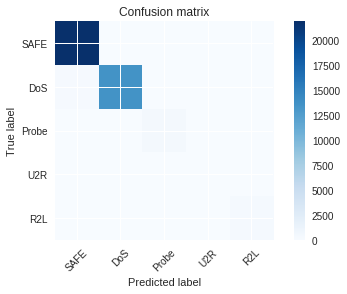

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21938
           1       1.00      0.99      0.99     13681
           2       0.97      0.92      0.94       424
           3       1.00      0.50      0.67        10
           4       0.87      0.89      0.88       344

   micro avg       0.99      0.99      0.99     36397
   macro avg       0.97      0.86      0.89     36397
weighted avg       0.99      0.99      0.99     36397



In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test_mc
pred2 = y_pred_logmc
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_lr_mc = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_lr_mc))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['SAFE','DoS','Probe','U2R','R2L'])
plt.show()
print(classification_report(y_true,pred2))

##KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn_mc = KNeighborsClassifier(n_neighbors=4)
print(knn_mc) 

knn_mc.fit(x_train_mc, y_train_mc)
y_pred_knn_mc = knn_mc.predict(x_test_mc)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')


Precision score: 0.9987251530257909
Recall score: 0.9987361595735912
F1 score: 0.998725425188046
[[21925     2     0     1    10]
 [    3 13678     0     0     0]
 [   12     0   412     0     0]
 [    3     0     0     7     0]
 [   12     2     1     0   329]]
Plot of Confusion Matrix


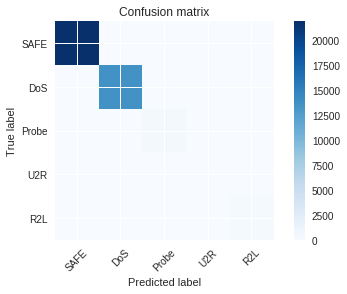

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     13681
           2       1.00      0.97      0.98       424
           3       0.88      0.70      0.78        10
           4       0.97      0.96      0.96       344

   micro avg       1.00      1.00      1.00     36397
   macro avg       0.97      0.93      0.94     36397
weighted avg       1.00      1.00      1.00     36397



In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test_mc
pred2 = y_pred_knn_mc
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_knn_mc = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_knn_mc))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['SAFE','DoS','Probe','U2R','R2L'])
plt.show()
print(classification_report(y_true,pred2))

##SVM

In [0]:
#import, instantiate, fit and predict the data
from sklearn.svm import SVC

#svm.svc
svm_modelmc = SVC(C=3)

svm_modelmc.fit(x_train_mc, y_train_mc)

y_pred_svm_mc = svm_modelmc.predict(x_test_mc)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Precision score: 0.9976738135605803
Recall score: 0.9976646426903316
F1 score: 0.9976516311323359
[[21907     6     2     0    23]
 [    7 13674     0     0     0]
 [   26     0   398     0     0]
 [    2     0     0     7     1]
 [   14     4     0     0   326]]
Plot of Confusion Matrix


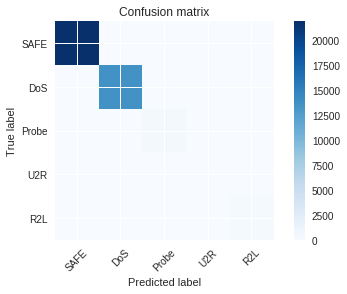

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     13681
           2       0.99      0.94      0.97       424
           3       1.00      0.70      0.82        10
           4       0.93      0.95      0.94       344

   micro avg       1.00      1.00      1.00     36397
   macro avg       0.98      0.92      0.95     36397
weighted avg       1.00      1.00      1.00     36397



In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
y_true = y_test_mc
pred2 = y_pred_svm_mc
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_svm_mc = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_svm_mc))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['SAFE','DoS','Probe','U2R','R2L'])
plt.show()
print(classification_report(y_true,pred2))

##GNB

In [0]:
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
clf2.fit(x_train_mc, y_train_mc)
y_pred_gnb_mc = clf2.predict(x_test_mc)

Precision score: 0.9718445936358199
Recall score: 0.8777097013490123
F1 score: 0.9170111821909642
[[20308   181   210  1083   156]
 [  216 11029  2379     0    57]
 [    1     3   413     4     3]
 [    0     0     0     9     1]
 [    6     1    22   128   187]]
Plot of Confusion Matrix


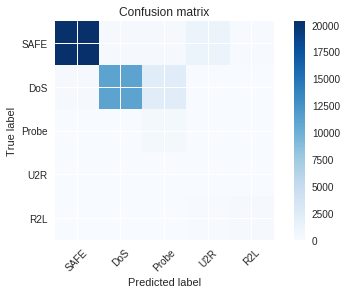

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     21938
           1       0.98      0.81      0.89     13681
           2       0.14      0.97      0.24       424
           3       0.01      0.90      0.01        10
           4       0.46      0.54      0.50       344

   micro avg       0.88      0.88      0.88     36397
   macro avg       0.52      0.83      0.52     36397
weighted avg       0.97      0.88      0.92     36397



In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

y_true = y_test_mc
pred2 = y_pred_gnb_mc
score = metrics.precision_score(y_true, pred2, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred2, average= "weighted")
print("Recall score: {}".format(score))
score_gnb_mc = metrics.f1_score(y_true, pred2, average= "weighted")
print("F1 score: {}".format(score_gnb_mc))
#score = metrics.log_loss(y_true, pred2) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,pred2)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['SAFE','DoS','Probe','U2R','R2L'])
plt.show()
print(classification_report(y_true,pred2))

##Fully connected Nueral Network

In [0]:
y_mc = pd.DataFrame(y_mc,columns=['connection'])
encode_text_dummy(y_mc,'connection')
print(x_mc.shape,y_mc.shape)

In [0]:
y_mc = np.array(y_mc)

In [0]:
x_mc
y_mc.shape

(145585, 5)

In [0]:
# Split into train/test
x_train3, x_test3, y_train3, y_test3 = train_test_split(x_mc, y_mc, test_size=0.25, random_state=42)

In [0]:
y_test3.shape

(36397, 5)

In [0]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
path = ""
save_path=""

In [0]:
checkpointer = ModelCheckpoint(filepath="neural_project3mc.hdf5", verbose=0, save_best_only=True) # save best model
Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

for i in range(5):
  print(i)
  model = Sequential()
  model.add(Dense(25, input_dim=x_mc.shape[1], activation='relu'))
  model.add(Dropout(0.01))
  model.add(Dense(25,activation='relu'))
  model.add(Dense(25,activation='relu'))
  model.add(Dense(25,activation='relu'))
  model.add(Dropout(0.2)) 
  model.add(Dense(5,activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

  model.fit(x_train3, y_train3,validation_data=(x_test3,y_test3),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred2 = model.predict(x_test3)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test3,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  #loop ends
  
print('Training finished')  
print()
#model.save(os.path.join(save_path,"neural_project3mc.hdf5"))

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 17s - loss: 0.0657 - acc: 0.9798 - val_loss: 0.0140 - val_acc: 0.9970
Epoch 2/100
 - 10s - loss: 0.0174 - acc: 0.9960 - val_loss: 0.0102 - val_acc: 0.9970
Epoch 3/100
 - 10s - loss: 0.0144 - acc: 0.9964 - val_loss: 0.0093 - val_acc: 0.9974
Epoch 4/100
 - 10s - loss: 0.0124 - acc: 0.9971 - val_loss: 0.0088 - val_acc: 0.9978
Epoch 5/100
 - 10s - loss: 0.0110 - acc: 0.9972 - val_loss: 0.0077 - val_acc: 0.9979
Epoch 6/100
 - 10s - loss: 0.0111 - acc: 0.9972 - val_loss: 0.0075 - val_acc: 0.9980
Epoch 7/100
 - 10s - loss: 0.0102 - acc: 0.9973 - val_loss: 0.0093 - val_acc: 0.9975
Epoch 8/100
 - 11s - loss: 0.0091 - acc: 0.9975 - val_loss: 0.0083 - val_acc: 0.9980
Epoch 9/100
 - 10s - loss: 0.0089 - acc: 0.9977 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 10/100
 - 10s - loss: 0.0081 - acc: 0.9979 - val_loss: 0.0074 - val_acc: 0.9981
Epoch 00010: early stopping
F1 score: 0.9980767624277952
1
Train on 109188 samples, validate on 

In [0]:
#the bset classification model for 5 stars
#loading the best saved model
from keras.models import load_model
model2 = load_model(os.path.join(save_path,"neural_project3mc.hdf5"))
predcn = model2.predict(x_test3)
predcn = np.argmax(predcn,axis=1)
y_true = np.argmax(y_test3,axis=1)
score = metrics.precision_score(y_true, predcn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predcn, average= "weighted")
print("Recall score: {}".format(score))
score_nn_mc = metrics.f1_score(y_true, predcn, average= "weighted")
print("F1 score: {}".format(score_nn_mc))
#score = metrics.log_loss(y_true, predcn) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predcn)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['SAFE','DoS','Probe','U2R','R2L'])
plt.show()
print(classification_report(y_true,predcn))

OSError: ignored

In [0]:

rank1 = perturbation_rank(model, x2_mc, y2_mc, names, False)
rank1

NameError: ignored

##CNN

In [0]:
print(x_mc.shape,y_mc.shape)

(145585, 58) (145585, 5)


In [0]:
# process the data to fit in a keras CNN properly， input data needs to be (N, X, Y, C) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size

x2_mc = x_mc.reshape((145585, 1, 58, 1))

# output labels should be one-hot vectors - ie,
# 0 -> [0, 0, 1]
# 1 -> [0, 1, 0]
# 2 -> [1, 0, 0]
# this operation changes the shape of y from (10000,1) to (10000, 3)
# Converts a class vector (integers) to binary class matrix.  
y2_mc = y_mc #alrady one hot encoded
print(x2_mc.shape,y2_mc.shape)

(145585, 1, 58, 1) (145585, 5)


In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import time

Using TensorFlow backend.


In [0]:
# split your data to training and test
x_train3, x_test3, y_train3, y_test3 = train_test_split(x2_mc, y2_mc, test_size=0.25, random_state=42)

In [0]:
print("x_train",x_train3.shape)
print("y_train",y_train3.shape)
print("x_test",x_test3.shape)
print("y_test",y_test3.shape)

x_train (109188, 1, 58, 1)
y_train (109188, 5)
x_test (36397, 1, 58, 1)
y_test (36397, 5)


In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 58, 1)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(67, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Dropout(0.25))    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(y2_mc.shape[1], activation="softmax"))

In [0]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 56, 64)         256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 28, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 28, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 26, 128)        24704     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 13, 128)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 13, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1664)              0         
__________

In [0]:
SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

start_time = time.time()
#checkpointer = ModelCheckpoint(filepath="cnn_project3mc.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(1):
  
  print(i)
  
  cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])


  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  cnn.fit(x_train3, y_train3,     
          batch_size=128,
          epochs=100,
          verbose=2,
          callbacks=[monitor],
          validation_data=(x_test3, y_test3))
   
  pred2 = cnn.predict(x_test3)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test3,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  
print('Training finished...Loading the best model')  
print()
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
cnn.save(os.path.join(save_path,"cnn_project3mc.hdf5"))         

0
Instructions for updating:
Use tf.cast instead.
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 76s - loss: 0.0535 - acc: 0.9869 - val_loss: 0.0183 - val_acc: 0.9958
Epoch 2/100
 - 75s - loss: 0.0223 - acc: 0.9946 - val_loss: 0.0165 - val_acc: 0.9954
Epoch 3/100
 - 75s - loss: 0.0201 - acc: 0.9955 - val_loss: 0.0115 - val_acc: 0.9970
Epoch 4/100
 - 75s - loss: 0.0173 - acc: 0.9958 - val_loss: 0.0134 - val_acc: 0.9973
Epoch 5/100
 - 76s - loss: 0.0164 - acc: 0.9962 - val_loss: 0.0103 - val_acc: 0.9972
Epoch 6/100
 - 75s - loss: 0.0142 - acc: 0.9966 - val_loss: 0.0090 - val_acc: 0.9976
Epoch 7/100
 - 75s - loss: 0.0131 - acc: 0.9968 - val_loss: 0.0104 - val_acc: 0.9972
Epoch 8/100
 - 75s - loss: 0.0134 - acc: 0.9967 - val_loss: 0.0152 - val_acc: 0.9974
Epoch 9/100
 - 75s - loss: 0.0122 - acc: 0.9971 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 10/100
 - 75s - loss: 0.0133 - acc: 0.9968 - val_loss: 0.0079 - val_acc: 0.9978
Epoch 11/100
 - 75s - loss: 0.0114 - acc: 0.9972

In [0]:
# evaluate() computes the loss and accuracy
score_CNN2 = cnn.evaluate(x_test3, y_test3, verbose=0)
print('Test loss: {}'.format(score_CNN2[0]))
print('Test accuracy: {}'.format(score_CNN2[1]))

Test loss: 0.007435984903608008
Test accuracy: 0.9980767645685084


Precision score: 0.998139885866569
Recall score: 0.9980767645685084
F1 score: 0.9980911084014968
[[21896     3     2     1    36]
 [    3 13678     0     0     0]
 [   10     0   413     1     0]
 [    2     0     0     6     2]
 [    9     1     0     0   334]]
Plot of Confusion Matrix


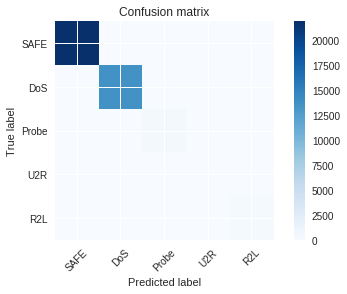

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     13681
           2       1.00      0.97      0.98       424
           3       0.75      0.60      0.67        10
           4       0.90      0.97      0.93       344

   micro avg       1.00      1.00      1.00     36397
   macro avg       0.93      0.91      0.92     36397
weighted avg       1.00      1.00      1.00     36397



In [0]:
from sklearn import metrics
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
model3 = load_model(os.path.join(save_path,"cnn_project3mc.hdf5"))
predcn = model3.predict(x_test3)
predcn = np.argmax(predcn,axis=1)
y_true = np.argmax(y_test3,axis=1)
score = metrics.precision_score(y_true, predcn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predcn, average= "weighted")
print("Recall score: {}".format(score))
score_cnmc = metrics.f1_score(y_true, predcn, average= "weighted")
print("F1 score: {}".format(score_cnmc))
#score = metrics.log_loss(y_true, predcn) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predcn)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['SAFE','DoS','Probe','U2R','R2L'])
plt.show()
print(classification_report(y_true,predcn))

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import regularizers
# define a CNN

cnn1 = Sequential()
cnn1.add(Conv2D(64, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 58, 1)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(67, 1)))

cnn1.add(MaxPooling2D(pool_size=(1,2)))
cnn1.add(Dropout(0.1))
cnn1.add(Conv2D(128, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu', 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01)))
cnn1.add(MaxPooling2D(pool_size=(1,2)))
cnn1.add(Dropout(0.1))    
    
cnn1.add(Flatten())
cnn1.add(Dense(1024, activation="relu"))
cnn1.add(Dropout(0.2))
cnn1.add(Dense(y2_mc.shape[1], activation="softmax"))
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 58, 64)         128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 29, 64)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 29, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 29, 128)        8320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 14, 128)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 14, 128)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1792)              0         
__________

In [0]:
SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="cnn1_project3mc1.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(1):
  
  print(i)
  
  cnn1.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])


  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  cnn1.fit(x_train3, y_train3,     
          batch_size=128,
          epochs=100,
          verbose=2,
          callbacks=[monitor,checkpointer],
          validation_data=(x_test3, y_test3))
   
  pred2 = cnn1.predict(x_test3)

  pred2 = np.argmax(pred2,axis=1) # raw probabilities to choose class (highest probability)

  y_true = np.argmax(y_test3,axis=1)
  score = metrics.f1_score(y_true, pred2, average= "weighted")
  print("F1 score: {}".format(score))
  
print('Training finished...Loading the best model')  
print()
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
#cnn.save(os.path.join(save_path,"cnn1_project3mc1.hdf5"))         

0
Train on 109188 samples, validate on 36397 samples
Epoch 1/100
 - 81s - loss: 1.6106 - acc: 0.9631 - val_loss: 0.4011 - val_acc: 0.9647
Epoch 2/100
 - 82s - loss: 0.2411 - acc: 0.9707 - val_loss: 0.1345 - val_acc: 0.9745
Epoch 3/100
 - 82s - loss: 0.1195 - acc: 0.9776 - val_loss: 0.0845 - val_acc: 0.9827
Epoch 4/100
 - 81s - loss: 0.0956 - acc: 0.9815 - val_loss: 0.0776 - val_acc: 0.9818
Epoch 5/100
 - 81s - loss: 0.0900 - acc: 0.9824 - val_loss: 0.0705 - val_acc: 0.9873
Epoch 6/100
 - 81s - loss: 0.0898 - acc: 0.9836 - val_loss: 0.0693 - val_acc: 0.9891
Epoch 7/100
 - 81s - loss: 0.0841 - acc: 0.9843 - val_loss: 0.0967 - val_acc: 0.9909
Epoch 8/100
 - 81s - loss: 0.0823 - acc: 0.9847 - val_loss: 0.0586 - val_acc: 0.9917
Epoch 9/100
 - 81s - loss: 0.0754 - acc: 0.9849 - val_loss: 0.0564 - val_acc: 0.9878
Epoch 10/100
 - 81s - loss: 0.0788 - acc: 0.9854 - val_loss: 0.0612 - val_acc: 0.9893
Epoch 11/100
 - 81s - loss: 0.0779 - acc: 0.9850 - val_loss: 0.0535 - val_acc: 0.9893
Epoch 12/1

Precision score: 0.998139885866569
Recall score: 0.9980767645685084
F1 score: 0.9980911084014968
[[21896     3     2     1    36]
 [    3 13678     0     0     0]
 [   10     0   413     1     0]
 [    2     0     0     6     2]
 [    9     1     0     0   334]]
Plot of Confusion Matrix


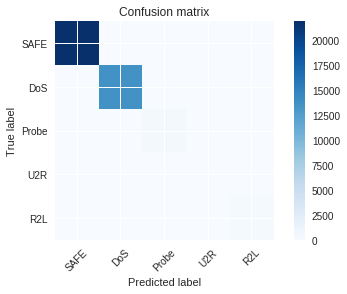

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     13681
           2       1.00      0.97      0.98       424
           3       0.75      0.60      0.67        10
           4       0.90      0.97      0.93       344

   micro avg       1.00      1.00      1.00     36397
   macro avg       0.93      0.91      0.92     36397
weighted avg       1.00      1.00      1.00     36397



In [0]:
from sklearn import metrics
from keras.models import load_model
model3 = load_model(os.path.join(save_path,"cnn1_project3mc1.hdf5"))
predcn = model3.predict(x_test3)
predcn = np.argmax(predcn,axis=1)
y_true = np.argmax(y_test3,axis=1)
score = metrics.precision_score(y_true, predcn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, predcn, average= "weighted")
print("Recall score: {}".format(score))
score_cnmc1 = metrics.f1_score(y_true, predcn, average= "weighted")
print("F1 score: {}".format(score_cnmc1))
#score = metrics.log_loss(y_true, predcn) #this was not working was showing y_true & y_pred both contain different classes 3 , 2.
#print("Log loss score: {}".format(score))
cm = confusion_matrix(y_true,predcn)
print(cm)
print('Plot of Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm,['SAFE','DoS','Probe','U2R','R2L'])
plt.show()
print(classification_report(y_true,predcn))